# Coronavirus Genome Identification

## Dataset: Corona v5.2 data 
from https://github.com/albertotonda/deep-learning-coronavirus-genome 

### PCR Amplicons sequencing procedure
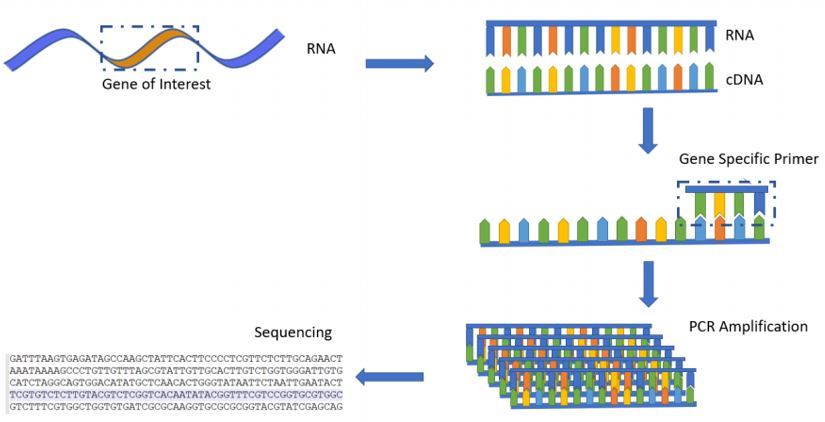

### coding of the input sequences
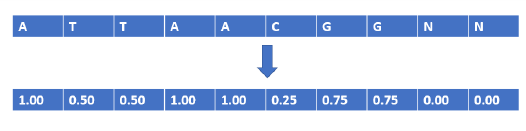

In [ ]:
import os
print(os.listdir('../input/data'))

In [ ]:
kfoldIndex =9 # 0 ~ 9
num_classes=2 
num_vectors=31029 # fixed size of the data

In [ ]:
import numpy as np
data = []
data = np.genfromtxt('../input/data/data.csv',delimiter=',')
data = np.array(data)
print('Dataset:', data.shape)

In [ ]:
from sklearn import preprocessing
standardScaler = preprocessing.StandardScaler()
data = standardScaler.fit_transform(data)

In [ ]:
def openVector(filepath):
    dat = []
    dat = np.genfromtxt(filepath,delimiter=' ')
    print(dat.shape)
    return dat

In [ ]:
labels = openVector('../input/data/labels.csv')
trainIndex= openVector('../input/data/index/'+str(kfoldIndex)+'train_index.txt')
valIndex  = openVector('../input/data/index/'+str(kfoldIndex)+'val_index.txt')
testIndex = openVector('../input/data/index/'+str(kfoldIndex)+'test_index.txt')

In [ ]:
trainIndex=trainIndex.astype(int)
valIndex=valIndex.astype(int)
testIndex=testIndex.astype(int)

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical

In [ ]:
trainX=[]
trainY=[]
for i in range (0,len(trainIndex)):
    trainY.append(labels[trainIndex[i]])
    temp=[]
    for j in range (0,len(data[0])):
        if(data[trainIndex[i]][j]==-1):
            temp.append(0)
        else:
            temp.append(data[trainIndex[i]][j])
    trainX.append(temp)

trainX=np.array(trainX)
trainY=np.array(trainY) 
print(trainX.shape)
print(trainY.shape)


# one-hot encoding
trainY=to_categorical(trainY)

In [ ]:
print(trainX[0])

In [ ]:
print(trainY[0])

In [ ]:
validX=[]
validY=[]
for i in range (0,len(valIndex)):
    validY.append(labels[valIndex[i]])
    temp=[]
    for j in range (0,len(data[0])):
        if(data[valIndex[i]][j]==-1):
            temp.append(0)
        else:
            temp.append(data[valIndex[i]][j])
    validX.append(temp)

validX=np.array(validX)
validY=np.array(validY) 
print(validX.shape)
print(validY.shape)

# one-hot encoding
validY=to_categorical(validY)

In [ ]:
testX=[]
testY=[]
for i in range (0,len(testIndex)):
    testY.append(labels[testIndex[i]])
    temp=[]
    for j in range (0,len(data[0])):
        if(data[testIndex[i]][j]==-1):
            temp.append(0)
        else:
            temp.append(data[testIndex[i]][j])
    testX.append(temp)

testX=np.array(testX)
testY=np.array(testY) 
print(testX.shape)
print(testY.shape)

# one-hot encoding
testY=to_categorical(testY)

## Build Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [ ]:
trainX = trainX.reshape(-1,1,num_vectors,1)
validX = validX.reshape(-1,1,num_vectors,1)
input_shape = (1,num_vectors,1)
print(trainX.shape)
print(validX.shape)
print(input_shape)

In [ ]:
model = Sequential()

# 1st Conv layer
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape = input_shape))
model.add(MaxPool2D((2,2), padding='same'))
# 2nd Conv layer        
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2), padding='same'))
# 3rd Conv layer        
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2), padding='same'))
# Fully Connected layer        
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

In [ ]:
# Compile Model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [ ]:
# Train Model
num_epochs = 10
model.fit(trainX, trainY, batch_size = 50, epochs = num_epochs, validation_data=(validX, validY));

In [ ]:
# Evaluate Model
testX = testX.reshape(-1,1,num_vectors,1)
score = model.evaluate(testX, testY, verbose = 0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

## Confusion Matrix report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
predY = model.predict(testX)
y_pred = np.argmax(predY,axis=1)
y_actual = np.argmax(testY,axis=1)
cm = confusion_matrix(y_actual, y_pred)
print(cm)

In [ ]:
print(classification_report(y_actual, y_pred, target_names=['SARS-CoV-2', 'others']))

## Confusion Matrix plot

In [ ]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
plot_confusion_matrix(cm, 
                      normalize=False,
                      target_names = ['SARS-CoV-2', 'others'],
                      title="Confusion Matrix, not Normalized")